In [ ]:
!pip install SimpleITK
!pip install optuna
!pip install monai

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import cv2

import optuna
import torch as tc
import torch.nn as nn
from torchvision import models
from torchvision.models.segmentation import FCN_ResNet50_Weights, DeepLabV3_MobileNet_V3_Large_Weights
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric

In [ ]:
def get_files(data_path, folder):
    names = []
    folder_path = os.path.join(data_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(subfolder_path):
            if file.endswith(".nrrd") and not file.endswith(".seg.nrrd"):
                names.append(os.path.join(subfolder_path, file))
    return names

def split_data(names_list, pre_test_size = 0.2, val_ratio = 0.5, seed=5):
    train_names, pre_test_names = train_test_split(names_list, test_size = pre_test_size, random_state = seed)
    val_names, test_names = train_test_split(pre_test_names, test_size = val_ratio, random_state = seed)
    return train_names, val_names, test_names

Data_path = r"/content/drive/MyDrive/Aorta_Segmentation/Data"

Dongyang_data_names = get_files(Data_path, "Dongyang")
KiTS_data_names = get_files(Data_path, "KiTS")
Rider_data_names = get_files(Data_path, "Rider")

D_train_names, D_val_names, D_test_names = split_data(Dongyang_data_names)
K_train_names, K_val_names, K_test_names = split_data(KiTS_data_names)
R_train_names, R_val_names, R_test_names = split_data(Rider_data_names)

train_data_names = D_train_names + K_train_names + R_train_names
val_data_names = D_val_names + K_val_names + R_val_names
test_data_names = D_test_names + K_test_names + R_test_names

In [ ]:
class Dataset(tc.utils.data.Dataset):
    def __init__(self, data_names):
        self.images = []
        self.masks = []
        self.images_names = []
        self.borders = []

        slice_index = 0

        for name in data_names:
            self.borders.append("First slice of " + os.path.basename(name) + ": " + str(slice_index))

            image = sitk.ReadImage(name)
            image = sitk.GetArrayFromImage(image).T
            if image.shape[1] == 666:   #Normalize shape of data
                image = image[:, 77:589, :]
            for i in range(image.shape[2]):
                self.images.append(image[:, :, i])   #Adding every slice separately
                self.images_names.append(os.path.basename(name) + "Slice" + str(i))
                slice_index += 1

            mask_path = name.replace(".nrrd", ".seg.nrrd")   #The masks have the same name as the files but their format is different
            if not os.path.exists(mask_path):
                raise ValueError(f"There is no mask for file {os.path.basename(name)}")

            mask = sitk.ReadImage(mask_path)
            mask = sitk.GetArrayFromImage(mask).T
            if mask.shape[1] == 666:   #Normalize shape of mask
                mask = mask[:, 77:589, :]
            for i in range(mask.shape[2]):
                self.masks.append(mask[:, :, i])   #To match slices of data we also slice masks

    def Preprocess_Data(self):
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
        for i in range(len(self.images)):
            image = self.images[i]
            if "R" in self.images_names[i]:   #Rider files have NaN values that are read as -2000
                image[image == -2000] = 0
            image = (image - np.min(image)) / (np.max(image) - np.min(image))   #Normalize to 0-1 range
            image = np.uint8(255*(image))   #Scale to uint8 in 0-255 range for CV2 functions
            image = cv2.resize(image, (224, 224))
            image = clahe.apply(image)   #Clahe increase the contrast
            self.images[i] = tc.from_numpy(np.float32(image)/255) #Preparing data so that the model can process it effectively

        for i in range(len(self.masks)):
            mask = self.masks[i]
            mask = cv2.resize(mask, (224, 224))
            mask = (mask > 0)
            self.masks[i] = tc.from_numpy(np.float32(mask))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.masks[index]

    def Get_name(self, index):
        return self.images_names[index]

    def Get_borders(self):
        print(self.borders)

In [ ]:
Testing_files = ['/content/drive/MyDrive/Aorta_Segmentation/Data/Dongyang/D6/D6.nrrd',
                 '/content/drive/MyDrive/Aorta_Segmentation/Data/KiTS/K10/K10.nrrd',
                 '/content/drive/MyDrive/Aorta_Segmentation/Data/Rider/R4/R4.nrrd']

Test_data = Dataset(Testing_files)
Test_data.Get_borders()

['First slice of D6.nrrd: 0', 'First slice of K10.nrrd: 159', 'First slice of R4.nrrd: 305']


Text(0.5, 1.0, 'R4 Preproccesed')

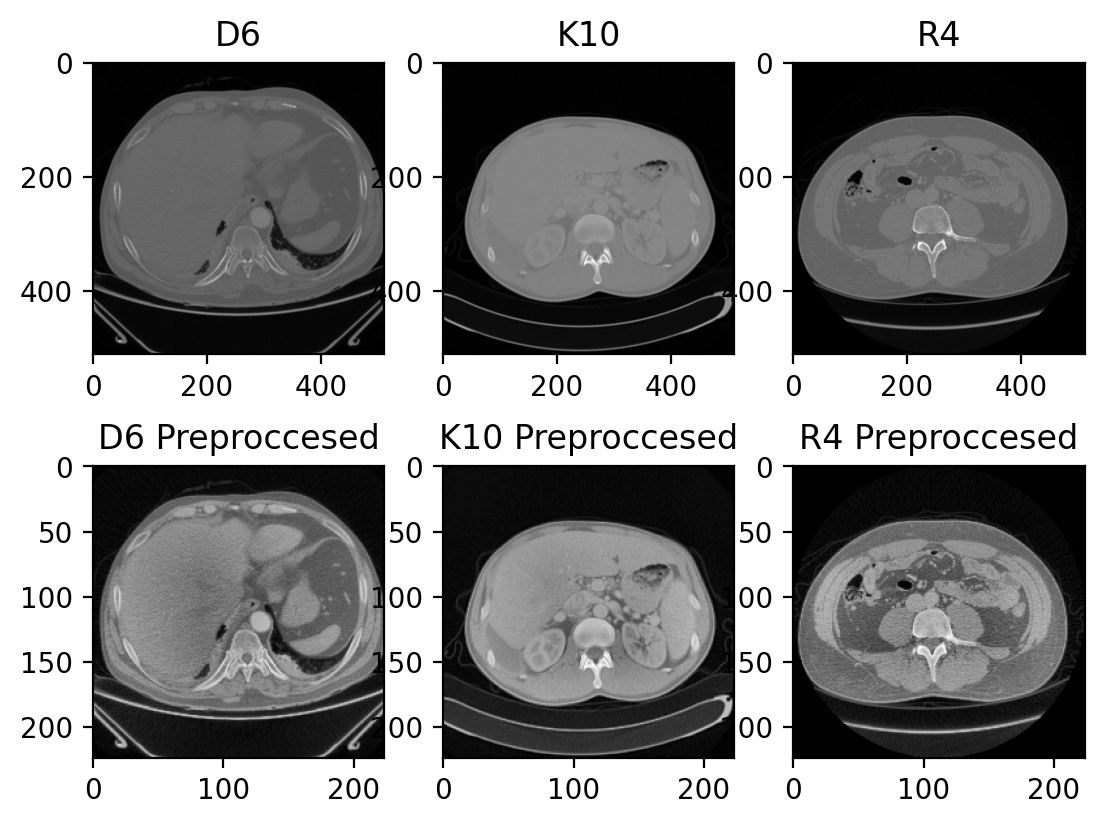

In [ ]:
D6_slice = (Test_data[80])[0]
K10_slice = (Test_data[230])[0]
R4_slice = (Test_data[700])[0]

Test_data.Preprocess_Data()

D6_slice_Preprocessed = (Test_data[80])[0]
K10_slice_Preprocessed = (Test_data[230])[0]
R4_slice_Preprocessed = (Test_data[700])[0]

plt.figure(dpi=200)
plt.subplot(2, 3, 1)
plt.imshow(D6_slice.T, cmap = "gray")
plt.title("D6")
plt.subplot(2, 3, 2)
plt.imshow(K10_slice.T, cmap = "gray")
plt.title("K10")
plt.subplot(2, 3, 3)
plt.imshow(R4_slice.T, cmap = "gray")
plt.title("R4")
plt.subplot(2, 3, 4)
plt.imshow(D6_slice_Preprocessed.T, cmap = "gray")
plt.title("D6 Preproccesed")
plt.subplot(2, 3, 5)
plt.imshow(K10_slice_Preprocessed.T, cmap = "gray")
plt.title("K10 Preproccesed")
plt.subplot(2, 3, 6)
plt.imshow(R4_slice_Preprocessed.T, cmap = "gray")
plt.title("R4 Preproccesed")

In [ ]:
Training_dataset = Dataset(train_data_names)
Training_dataset.Preprocess_Data()

Validation_dataset = Dataset(val_data_names)
Validation_dataset.Preprocess_Data()

In [ ]:
def Train_model(model, training_loader, validation_loader, learning_rate, num_epochs, Early_stopping = True, mode = "Study"):
    objective_function = DiceLoss(sigmoid=True)
    optimizer = tc.optim.Adam(model.parameters(), lr=learning_rate)
    device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
    model = model.to(device)
    if tc.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience = 0
    patience_limit = 3

    print(f"Training Dataset size: {len(training_loader.dataset)}") if mode == "Training" else None
    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch}") if mode == "Training" else None
        epoch_loss = 0.0
        val_epoch_loss = 0.0

        model.train()
        for images, masks in training_loader:
            images, masks = images.to(device), masks.to(device)
            output = model(images.unsqueeze(1))
            if isinstance(output, dict):
                output = output["out"]
            loss = objective_function(output, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item() * images.size(0)

        model.eval()
        with tc.no_grad():
            for images, masks in validation_loader:
                images, masks = images.to(device), masks.to(device)
                output = model(images.unsqueeze(1))
                if isinstance(output, dict):
                    output = output["out"]
                val_loss = objective_function(output, masks.unsqueeze(1))
                val_epoch_loss += val_loss.item() * images.size(0)

        epoch_loss = epoch_loss / len(training_loader.dataset)
        val_epoch_loss = val_epoch_loss / len(validation_loader.dataset)
        losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        print(f"Current epoch loss: {epoch_loss}") if mode == "Training" else None
        print(f"Current validation epoch loss: {val_epoch_loss}") if mode == "Training" else None

        if Early_stopping == True:
            if val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                patience = 0
            else:
                patience += 1
            if patience >= patience_limit:
                print(f"Early stoping triggered at epoch {epoch+1}")
                break

    return losses, val_losses, model

In [ ]:
Best_val_loss = float("inf")

def objective(trial):
    global Best_val_loss
    channels = trial.suggest_categorical("channels", [[16, 32, 64, 128], [16, 32, 64, 128, 256]])
    dropout = trial.suggest_float("dropout", 0.0, 0.2)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 15)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=32, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=32, shuffle=True)

    strides = (2,) * (len(channels) - 1)
    model = UNet(
        spatial_dims = 2,
        in_channels=1,
        out_channels=1,
        channels=channels,
        strides=strides,
        dropout=dropout
    )

    Final_losses, Final_val_losses, model = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, Early_stopping = True, mode = "Study")

    if Final_val_losses[-1] < Best_val_loss:
        Best_val_loss = Final_val_losses[-1]
        losses_dict = {'train_loss_lst': Final_losses, 'val_loss_lst': Final_val_losses}
        tc.save(losses_dict, '/content/drive/MyDrive/Aorta_Segmentation/Losses_values/UNet_losses.pt')
        tc.save(model.state_dict(), '/content/drive/MyDrive/Aorta_Segmentation/Models/UNet_trained.pth')

    best_epoch = Final_val_losses.index(min(Final_val_losses)) + 1
    print(f"Best epoch: {best_epoch}")
    return min(Final_val_losses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
tc.cuda.empty_cache()
print("Best parameters:", study.best_trial.params)

[I 2025-04-16 06:53:18,252] A new study created in memory with name: no-name-ec506a12-6ac3-449b-a568-2c3719594046
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 32, 64, 128, 256] which is of type list.
  warnings.warn(message)
[I 2025-04-16 06:56:38,009] Trial 0 finished with value: 0.32724597053572957 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.05954457538304534, 'learning_rate': 0.0006718550391325637, 'num_epochs': 10}. Best is trial 0 with value: 0.32724597053572957.


Best epoch: 10


[I 2025-04-16 06:58:38,240] Trial 1 finished with value: 0.30027428993291283 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.16274768240000864, 'learning_rate': 0.0028376100987969337, 'num_epochs': 6}. Best is trial 1 with value: 0.30027428993291283.


Best epoch: 5


[I 2025-04-16 07:03:38,496] Trial 2 finished with value: 0.31409988023505225 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.005503439246068976, 'learning_rate': 0.0014823490786628252, 'num_epochs': 15}. Best is trial 1 with value: 0.30027428993291283.


Early stoping triggered at epoch 15
Best epoch: 12


[I 2025-04-16 07:05:58,618] Trial 3 finished with value: 0.3181876686845292 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.17158820479896034, 'learning_rate': 0.0003182424054563302, 'num_epochs': 7}. Best is trial 1 with value: 0.30027428993291283.


Best epoch: 6


[I 2025-04-16 07:08:58,440] Trial 4 finished with value: 0.3631880323781576 and parameters: {'channels': [16, 32, 64, 128], 'dropout': 0.02823561342915737, 'learning_rate': 0.0002254240519413977, 'num_epochs': 10}. Best is trial 1 with value: 0.30027428993291283.


Best epoch: 9


[I 2025-04-16 07:11:58,403] Trial 5 finished with value: 0.2875171650659399 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.16340957694375052, 'learning_rate': 0.0009795363340852914, 'num_epochs': 9}. Best is trial 5 with value: 0.2875171650659399.


Best epoch: 7


[I 2025-04-16 07:14:18,326] Trial 6 finished with value: 0.8249926578359273 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.019594952524617338, 'learning_rate': 4.2292140003293546e-05, 'num_epochs': 7}. Best is trial 5 with value: 0.2875171650659399.


Best epoch: 7


[I 2025-04-16 07:16:58,312] Trial 7 finished with value: 0.9764126877679433 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.16264645458406302, 'learning_rate': 1.0180708441080856e-05, 'num_epochs': 8}. Best is trial 5 with value: 0.2875171650659399.


Best epoch: 8


[I 2025-04-16 07:18:28,212] Trial 8 finished with value: 0.3645697845269453 and parameters: {'channels': [16, 32, 64, 128], 'dropout': 0.19833846774840927, 'learning_rate': 0.0003603025368991808, 'num_epochs': 5}. Best is trial 5 with value: 0.2875171650659399.


Best epoch: 5


[I 2025-04-16 07:20:48,048] Trial 9 finished with value: 0.30930542757834545 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.09304548489002296, 'learning_rate': 0.0028604726950658644, 'num_epochs': 14}. Best is trial 5 with value: 0.2875171650659399.


Early stoping triggered at epoch 7
Best epoch: 4


[I 2025-04-16 07:21:23,985] Trial 10 finished with value: 0.3496866959502644 and parameters: {'channels': [16, 32, 64, 128], 'dropout': 0.12147127336643425, 'learning_rate': 0.007777375930905348, 'num_epochs': 2}. Best is trial 5 with value: 0.2875171650659399.


Best epoch: 2


[I 2025-04-16 07:22:43,971] Trial 11 finished with value: 0.28256356246087827 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.13279318432186404, 'learning_rate': 0.009289081202875494, 'num_epochs': 4}. Best is trial 11 with value: 0.28256356246087827.


Best epoch: 4


[I 2025-04-16 07:23:44,093] Trial 12 finished with value: 0.30988193357404475 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.12300830142650099, 'learning_rate': 0.009363011310912444, 'num_epochs': 3}. Best is trial 11 with value: 0.28256356246087827.


Best epoch: 3


[I 2025-04-16 07:26:24,271] Trial 13 finished with value: 0.2804062917405499 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.12643763904542435, 'learning_rate': 0.0014668839037208048, 'num_epochs': 12}. Best is trial 13 with value: 0.2804062917405499.


Early stoping triggered at epoch 8
Best epoch: 5


[I 2025-04-16 07:30:00,498] Trial 14 finished with value: 0.29236039688534543 and parameters: {'channels': [16, 32, 64, 128], 'dropout': 0.09655324303647153, 'learning_rate': 0.003573550330098675, 'num_epochs': 12}. Best is trial 13 with value: 0.2804062917405499.


Best epoch: 11


[I 2025-04-16 07:34:00,640] Trial 15 finished with value: 0.35967725176916515 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.12940575212728223, 'learning_rate': 0.00010619509991758805, 'num_epochs': 12}. Best is trial 13 with value: 0.2804062917405499.


Best epoch: 11


[I 2025-04-16 07:35:20,286] Trial 16 finished with value: 0.30334228662662327 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.0738377977100354, 'learning_rate': 0.004842718879979224, 'num_epochs': 4}. Best is trial 13 with value: 0.2804062917405499.


Best epoch: 4


[I 2025-04-16 07:38:00,926] Trial 17 finished with value: 0.31076644046073454 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.13864279111756908, 'learning_rate': 0.0012312542772044636, 'num_epochs': 12}. Best is trial 13 with value: 0.2804062917405499.


Early stoping triggered at epoch 8
Best epoch: 5


[I 2025-04-16 07:40:42,789] Trial 18 finished with value: 0.3213723215394968 and parameters: {'channels': [16, 32, 64, 128], 'dropout': 0.056728124462157484, 'learning_rate': 0.0017276527717639011, 'num_epochs': 13}. Best is trial 13 with value: 0.2804062917405499.


Early stoping triggered at epoch 9
Best epoch: 6


[I 2025-04-16 07:43:23,441] Trial 19 finished with value: 0.28815336398521807 and parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.1987699033489141, 'learning_rate': 0.00969156237528058, 'num_epochs': 10}. Best is trial 13 with value: 0.2804062917405499.


Early stoping triggered at epoch 8
Best epoch: 5
Best parameters: {'channels': [16, 32, 64, 128, 256], 'dropout': 0.12643763904542435, 'learning_rate': 0.0014668839037208048, 'num_epochs': 12}


In [ ]:
Best_val_loss = float("inf")

def pytorch_objective_FCN(trial):
    global Best_val_loss
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 15)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=64, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=64, shuffle=True)

    model = models.segmentation.fcn_resnet50(weights=None, num_classes=1)
    model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    Final_losses, Final_val_losses, model = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, Early_stopping = True, mode = "Study")

    if Final_val_losses[-1] < Best_val_loss:
        Best_val_loss = Final_val_losses[-1]
        losses_dict = {'train_loss_lst': Final_losses, 'val_loss_lst': Final_val_losses}
        tc.save(losses_dict, '/content/drive/MyDrive/Aorta_Segmentation/Losses_values/FCN_losses.pt')
        tc.save(model.state_dict(), '/content/drive/MyDrive/Aorta_Segmentation/Models/FCN_trained.pth')

    best_epoch = Final_val_losses.index(min(Final_val_losses)) + 1
    print(f"Best epoch: {best_epoch}")
    return min(Final_val_losses)


study = optuna.create_study(direction="minimize")
study.optimize(pytorch_objective_FCN, n_trials=5)
tc.cuda.empty_cache()
print("Best parameters deeplabv3 not pretrained:", study.best_trial.params)

[I 2025-04-16 07:43:23,468] A new study created in memory with name: no-name-e13f9321-d55e-49bc-9027-c964e6d75d96
[I 2025-04-16 09:09:31,834] Trial 0 finished with value: 0.29646253017032936 and parameters: {'learning_rate': 0.00039696059784863114, 'num_epochs': 7}. Best is trial 0 with value: 0.29646253017032936.


Best epoch: 7


[I 2025-04-16 10:10:58,182] Trial 1 finished with value: 0.3024231845084049 and parameters: {'learning_rate': 0.0006762649284194763, 'num_epochs': 5}. Best is trial 0 with value: 0.29646253017032936.


Best epoch: 4


[I 2025-04-16 12:14:06,977] Trial 2 finished with value: 0.28618906668684085 and parameters: {'learning_rate': 0.0002587757757317185, 'num_epochs': 10}. Best is trial 2 with value: 0.28618906668684085.


Best epoch: 10


[I 2025-04-16 14:14:16,473] Trial 3 finished with value: 0.3271041445739638 and parameters: {'learning_rate': 0.005400148964517831, 'num_epochs': 10}. Best is trial 2 with value: 0.28618906668684085.


Best epoch: 10


[I 2025-04-16 15:15:34,968] Trial 4 finished with value: 0.3242090319985471 and parameters: {'learning_rate': 0.0013079482845812895, 'num_epochs': 9}. Best is trial 2 with value: 0.28618906668684085.


Early stoping triggered at epoch 5
Best epoch: 2
Best parameters deeplabv3 not pretrained: {'learning_rate': 0.0002587757757317185, 'num_epochs': 10}


In [ ]:
Best_val_loss = float("inf")

def pytorch_objective_FCN_pretrained(trial):
    global Best_val_loss
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 15)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=64, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=64, shuffle=True)

    model = models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights)
    model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)

    Final_losses, Final_val_losses, model = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, Early_stopping = True, mode = "Study")

    if Final_val_losses[-1] < Best_val_loss:
        Best_val_loss = Final_val_losses[-1]
        losses_dict = {'train_loss_lst': Final_losses, 'val_loss_lst': Final_val_losses}
        tc.save(losses_dict, '/content/drive/MyDrive/Aorta_Segmentation/Losses_values/FCN_pretrained_losses.pt')
        tc.save(model.state_dict(), '/content/drive/MyDrive/Aorta_Segmentation/Models/FCN_pretrained_trained.pth')

    best_epoch = Final_val_losses.index(min(Final_val_losses)) + 1
    print(f"Best epoch: {best_epoch}")
    return min(Final_val_losses)


study = optuna.create_study(direction="minimize")
study.optimize(pytorch_objective_FCN_pretrained, n_trials=5)
tc.cuda.empty_cache()
print("Best parameters FCN pretrained:", study.best_trial.params)

[I 2025-04-16 20:21:01,277] A new study created in memory with name: no-name-fe85989e-ff29-4ecd-8b5d-6729829e9981
[I 2025-04-16 22:28:58,651] Trial 0 finished with value: 0.5029618394111609 and parameters: {'learning_rate': 2.80792299612661e-05, 'num_epochs': 8}. Best is trial 0 with value: 0.5029618394111609.


Best epoch: 8


[I 2025-04-17 01:08:59,091] Trial 1 finished with value: 0.4195569042903768 and parameters: {'learning_rate': 3.417303211158065e-05, 'num_epochs': 10}. Best is trial 1 with value: 0.4195569042903768.


Best epoch: 10
Early stoping triggered at epoch 6


[I 2025-04-17 02:43:47,668] Trial 2 finished with value: 0.3091354641816593 and parameters: {'learning_rate': 0.0008400350504479854, 'num_epochs': 8}. Best is trial 2 with value: 0.3091354641816593.


Best epoch: 3


[I 2025-04-17 04:45:36,450] Trial 3 finished with value: 0.36074165374698697 and parameters: {'learning_rate': 0.0049394671181112555, 'num_epochs': 8}. Best is trial 2 with value: 0.3091354641816593.


Best epoch: 7
Early stoping triggered at epoch 13


[I 2025-04-17 08:12:04,070] Trial 4 finished with value: 0.2957032154599199 and parameters: {'learning_rate': 0.00022160311919661968, 'num_epochs': 14}. Best is trial 4 with value: 0.2957032154599199.


Best epoch: 10
Best parameters FCN pretrained: {'learning_rate': 0.00022160311919661968, 'num_epochs': 14}


In [ ]:
Best_val_loss = float("inf")

def objective_deeplabv3(trial):
    global Best_val_loss
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 20)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=64, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=64, shuffle=True)

    model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=None, num_classes=1)
    model.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)

    Final_losses, Final_val_losses, model = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, Early_stopping = True, mode = "Study")

    if Final_val_losses[-1] < Best_val_loss:
        Best_val_loss = Final_val_losses[-1]
        losses_dict = {'train_loss_lst': Final_losses, 'val_loss_lst': Final_val_losses}
        tc.save(losses_dict, '/content/drive/MyDrive/Aorta_Segmentation/Losses_values/deeplabv3_losses.pt')
        tc.save(model.state_dict(), '/content/drive/MyDrive/Aorta_Segmentation/Models/deeplabv3_trained.pth')

    best_epoch = Final_val_losses.index(min(Final_val_losses)) + 1
    print(f"Best epoch: {best_epoch}")
    return min(Final_val_losses)


study = optuna.create_study(direction="minimize")
study.optimize(objective_deeplabv3, n_trials=10)
tc.cuda.empty_cache()
print("Best parameters deeplabv3 not pretrained:", study.best_trial.params)

[I 2025-04-20 06:40:40,801] A new study created in memory with name: no-name-e48d9c22-9797-45b2-b991-ff6900c51b24
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 118MB/s] 


Early stoping triggered at epoch 6


[I 2025-04-20 06:53:02,071] Trial 0 finished with value: 0.4888653091451723 and parameters: {'learning_rate': 0.0032611910368213993, 'num_epochs': 7}. Best is trial 0 with value: 0.4888653091451723.


Best epoch: 3


[I 2025-04-20 07:09:29,499] Trial 1 finished with value: 0.47962699271150944 and parameters: {'learning_rate': 0.004706068531259832, 'num_epochs': 18}. Best is trial 1 with value: 0.47962699271150944.


Early stoping triggered at epoch 8
Best epoch: 5


[I 2025-04-20 07:34:17,795] Trial 2 finished with value: 0.5620479113672058 and parameters: {'learning_rate': 0.00016587791690518173, 'num_epochs': 12}. Best is trial 1 with value: 0.47962699271150944.


Best epoch: 12


[I 2025-04-20 07:48:45,694] Trial 3 finished with value: 0.6153560890008223 and parameters: {'learning_rate': 9.770612742868502e-05, 'num_epochs': 7}. Best is trial 1 with value: 0.47962699271150944.


Best epoch: 7


[I 2025-04-20 08:11:14,871] Trial 4 finished with value: 0.5339108148959909 and parameters: {'learning_rate': 0.009810221268176258, 'num_epochs': 12}. Best is trial 1 with value: 0.47962699271150944.


Early stoping triggered at epoch 11
Best epoch: 8


[I 2025-04-20 08:31:55,116] Trial 5 finished with value: 0.5243047749394498 and parameters: {'learning_rate': 0.00041418030290454357, 'num_epochs': 10}. Best is trial 1 with value: 0.47962699271150944.


Best epoch: 9


[I 2025-04-20 08:54:34,158] Trial 6 finished with value: 0.4658696273523926 and parameters: {'learning_rate': 0.0025929337390757047, 'num_epochs': 19}. Best is trial 6 with value: 0.4658696273523926.


Early stoping triggered at epoch 11
Best epoch: 8


[I 2025-04-20 09:11:05,558] Trial 7 finished with value: 0.5043184903893937 and parameters: {'learning_rate': 0.0004349503006462952, 'num_epochs': 8}. Best is trial 6 with value: 0.4658696273523926.


Best epoch: 8


[I 2025-04-20 09:17:16,912] Trial 8 finished with value: 0.4947552272950061 and parameters: {'learning_rate': 0.0016536755720878017, 'num_epochs': 3}. Best is trial 6 with value: 0.4658696273523926.


Best epoch: 3


[I 2025-04-20 09:35:44,355] Trial 9 finished with value: 0.498808325277142 and parameters: {'learning_rate': 0.0055625594939345355, 'num_epochs': 9}. Best is trial 6 with value: 0.4658696273523926.


Early stoping triggered at epoch 9
Best epoch: 6
Best parameters deeplabv3 not pretrained: {'learning_rate': 0.0025929337390757047, 'num_epochs': 19}


In [ ]:
Best_val_loss = float("inf")

def objective_deeplabv3_pretrained(trial):
    global Best_val_loss
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    num_epochs = trial .suggest_int("num_epochs", 2, 20)

    Training_loader = tc.utils.data.DataLoader(Training_dataset, batch_size=64, shuffle=True)
    Validation_loader = tc.utils.data.DataLoader(Validation_dataset, batch_size=64, shuffle=True)

    model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights)
    model.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

    Final_losses, Final_val_losses, model = Train_model(model, Training_loader, Validation_loader, learning_rate, num_epochs, Early_stopping = True, mode = "Study")

    if Final_val_losses[-1] < Best_val_loss:
        Best_val_loss = Final_val_losses[-1]
        losses_dict = {'train_loss_lst': Final_losses, 'val_loss_lst': Final_val_losses}
        tc.save(losses_dict, '/content/drive/MyDrive/Aorta_Segmentation/Losses_values/deeplabv3_pretrained_losses.pt')
        tc.save(model.state_dict(), '/content/drive/MyDrive/Aorta_Segmentation/Models/deeplabv3_pretrained_trained.pth')

    best_epoch = Final_val_losses.index(min(Final_val_losses)) + 1
    print(f"Best epoch: {best_epoch}")
    return min(Final_val_losses)


study = optuna.create_study(direction="minimize")
study.optimize(objective_deeplabv3_pretrained, n_trials=10)
tc.cuda.empty_cache()
print("Best parameters deeplabv3 pretrained:", study.best_trial.params)

[I 2025-04-20 19:32:24,427] A new study created in memory with name: no-name-3b0d31cf-4357-487d-80bf-d42b16dace55
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 204MB/s]
[I 2025-04-20 19:50:46,151] Trial 0 finished with value: 0.5648757538960936 and parameters: {'learning_rate': 0.0003176930713019809, 'num_epochs': 9}. Best is trial 0 with value: 0.5648757538960936.


Best epoch: 9


[I 2025-04-20 20:09:08,603] Trial 1 finished with value: 0.4747541451867823 and parameters: {'learning_rate': 0.0033518775000839275, 'num_epochs': 11}. Best is trial 1 with value: 0.4747541451867823.


Early stoping triggered at epoch 9
Best epoch: 6


[I 2025-04-20 20:29:33,695] Trial 2 finished with value: 0.48560040117438286 and parameters: {'learning_rate': 0.004348097463075958, 'num_epochs': 10}. Best is trial 1 with value: 0.4747541451867823.


Best epoch: 9


[I 2025-04-20 20:52:04,272] Trial 3 finished with value: 0.4830307970851754 and parameters: {'learning_rate': 0.0019797141843953875, 'num_epochs': 15}. Best is trial 1 with value: 0.4747541451867823.


Early stoping triggered at epoch 11
Best epoch: 8


[I 2025-04-20 21:12:33,126] Trial 4 finished with value: 0.4887263724104463 and parameters: {'learning_rate': 0.0008139574090710798, 'num_epochs': 10}. Best is trial 1 with value: 0.4747541451867823.


Best epoch: 10


[I 2025-04-20 21:39:12,070] Trial 5 finished with value: 0.5372857643226719 and parameters: {'learning_rate': 0.00044479322761198636, 'num_epochs': 17}. Best is trial 1 with value: 0.4747541451867823.


Early stoping triggered at epoch 13
Best epoch: 10


[I 2025-04-20 22:07:52,155] Trial 6 finished with value: 0.5084592316428945 and parameters: {'learning_rate': 0.0005358366378800444, 'num_epochs': 14}. Best is trial 1 with value: 0.4747541451867823.


Best epoch: 13


[I 2025-04-20 22:38:47,881] Trial 7 finished with value: 0.6315961271430416 and parameters: {'learning_rate': 4.966559984901679e-05, 'num_epochs': 15}. Best is trial 1 with value: 0.4747541451867823.


Best epoch: 14


[I 2025-04-20 23:01:29,512] Trial 8 finished with value: 0.5507389643590909 and parameters: {'learning_rate': 0.00027304802088559145, 'num_epochs': 11}. Best is trial 1 with value: 0.4747541451867823.


Best epoch: 11


[I 2025-04-20 23:24:09,101] Trial 9 finished with value: 0.5028139884915638 and parameters: {'learning_rate': 0.0010745977628906478, 'num_epochs': 14}. Best is trial 1 with value: 0.4747541451867823.


Early stoping triggered at epoch 11
Best epoch: 8
Best parameters deeplabv3 pretrained: {'learning_rate': 0.0033518775000839275, 'num_epochs': 11}


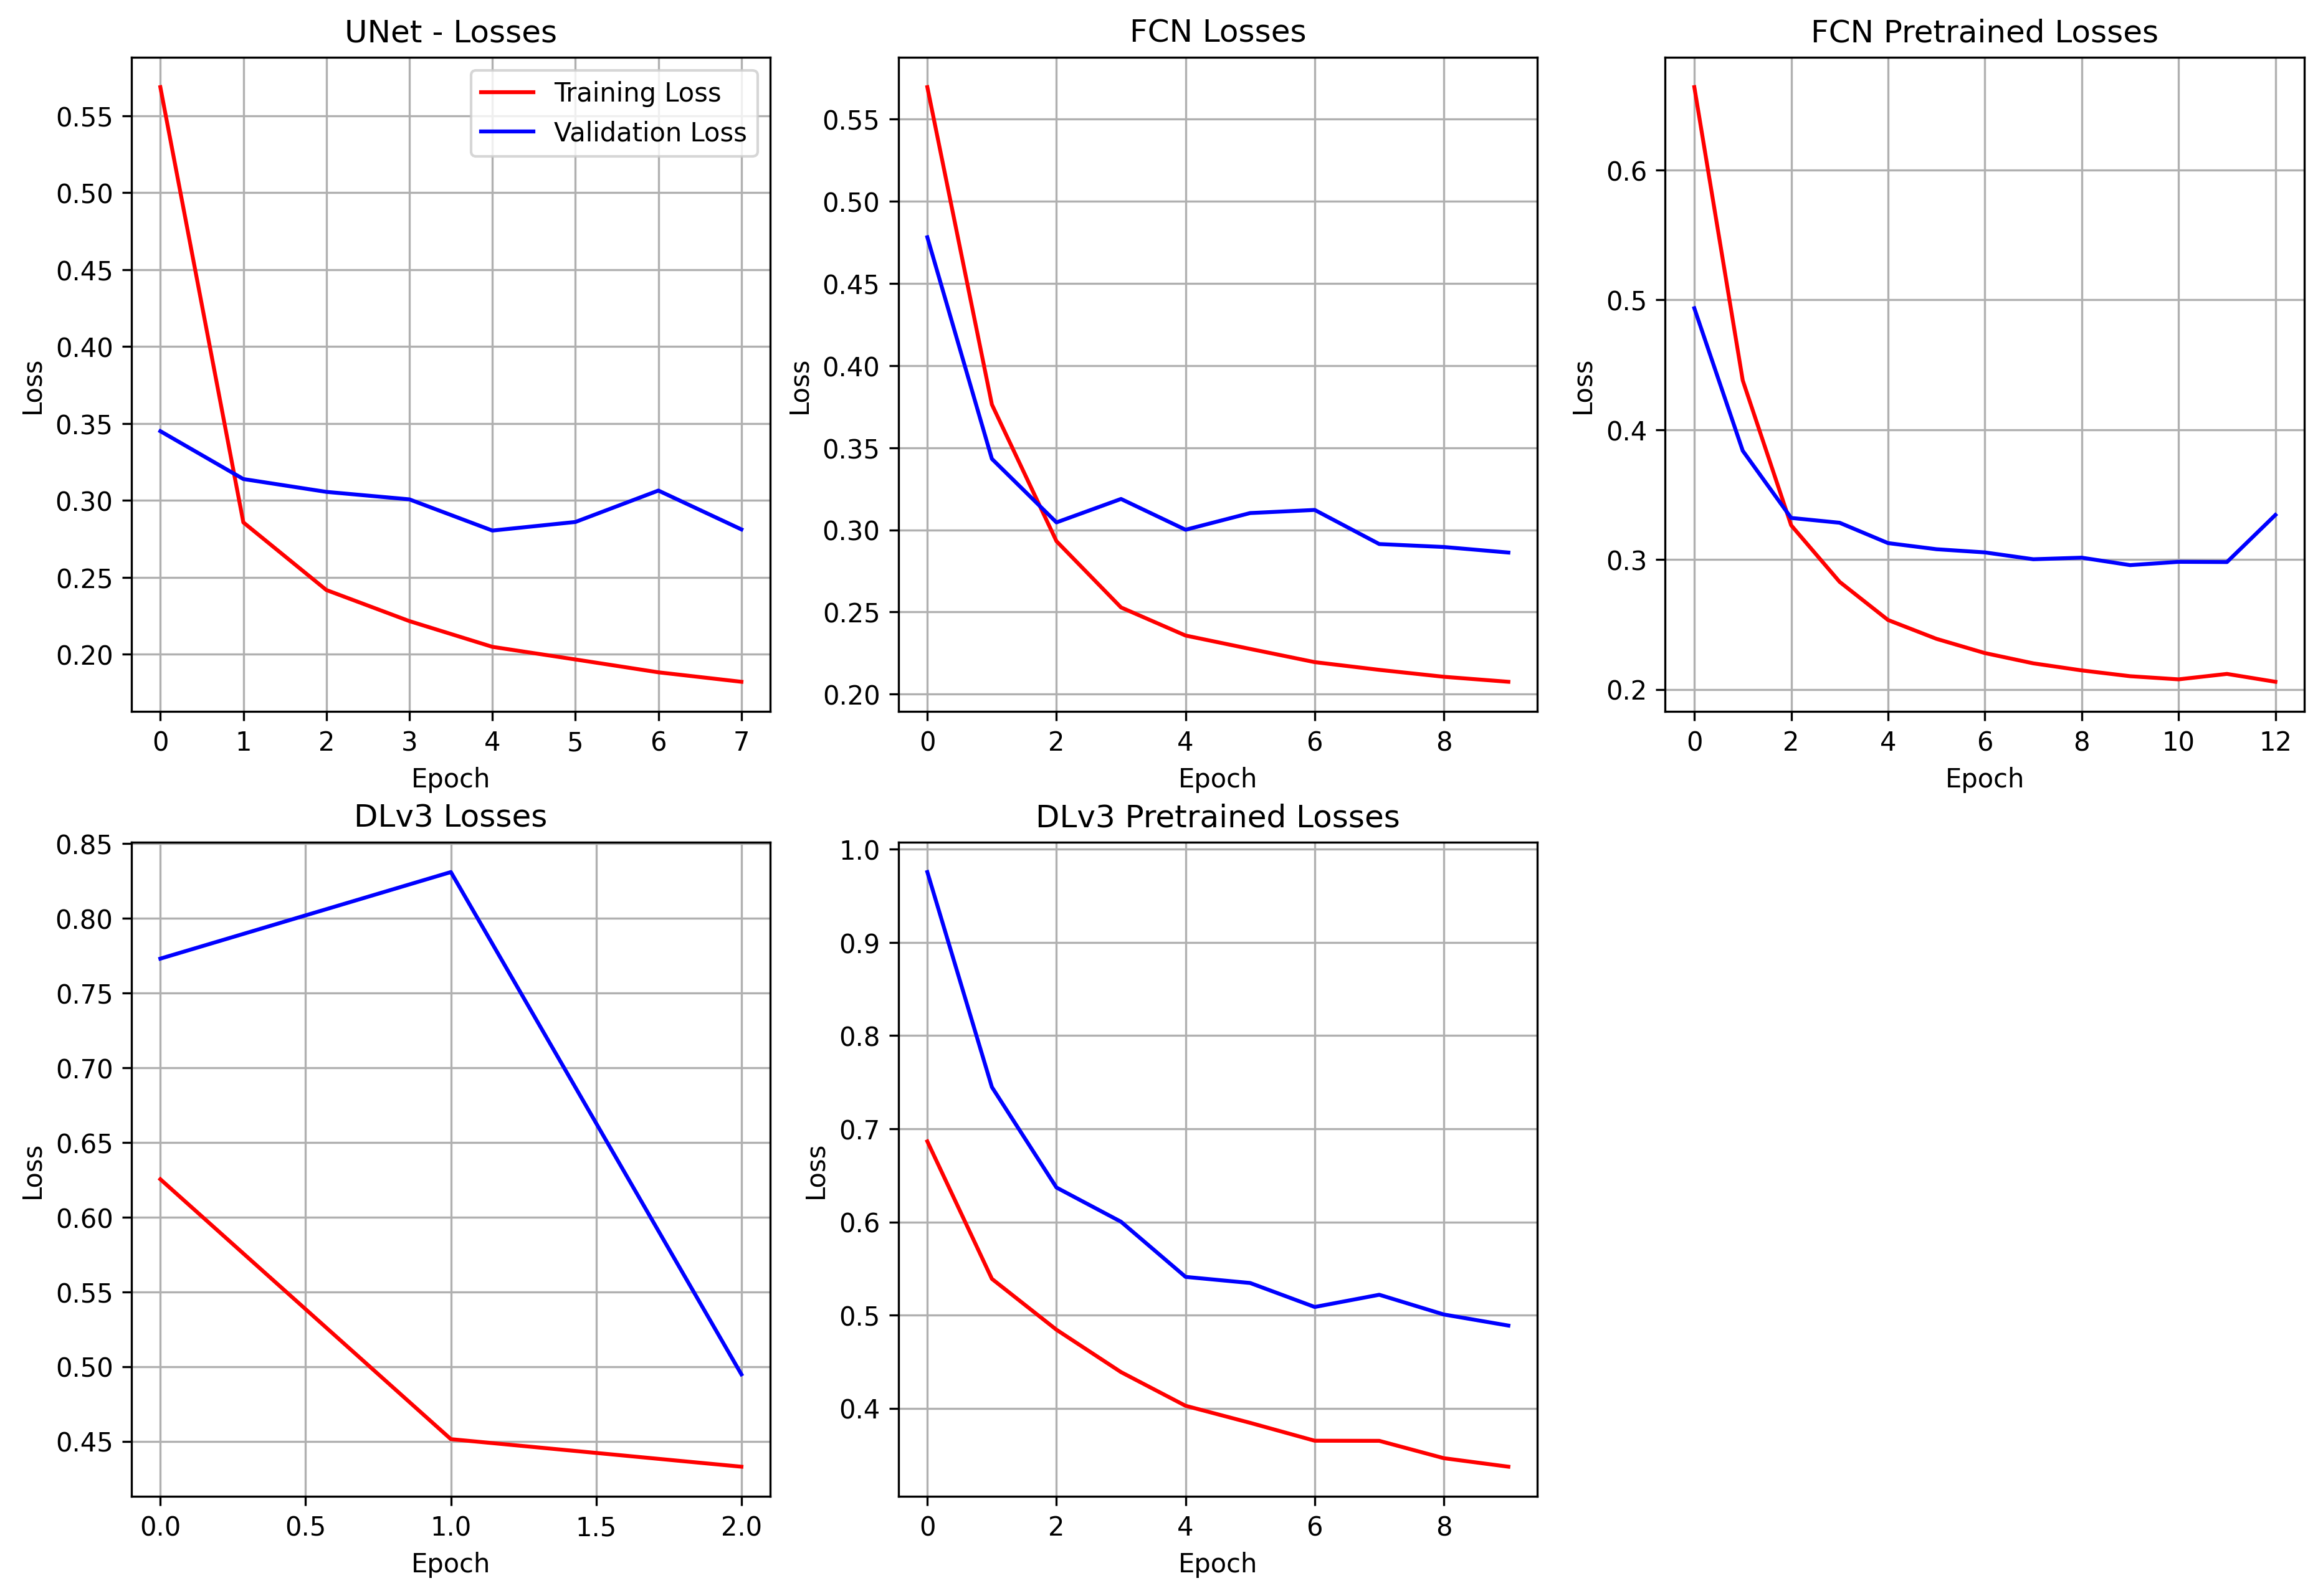

In [ ]:
def get_losses_from_path(path):
    losses_dict = tc.load(path)
    train_loss_lst = losses_dict["train_loss_lst"]
    val_loss_lst = losses_dict["val_loss_lst"]
    return train_loss_lst, val_loss_lst

Unet_train_losses, Unet_val_losses = get_losses_from_path('/content/drive/MyDrive/Aorta_Segmentation/Losses_values/UNet_losses.pt')
FCN_train_losses, FCN_val_losses = get_losses_from_path('/content/drive/MyDrive/Aorta_Segmentation/Losses_values/FCN_losses.pt')
FCN_pretrained_train_losses, FCN_pretrained_val_losses = get_losses_from_path('/content/drive/MyDrive/Aorta_Segmentation/Losses_values/FCN_pretrained_losses.pt')
Deeplabv3_train_losses, Deeplabv3_val_losses = get_losses_from_path('/content/drive/MyDrive/Aorta_Segmentation/Losses_values/deeplabv3_losses.pt')
Deeplabv3_pretrained_train_losses, Deeplabv3_pretrained_val_losses = get_losses_from_path('/content/drive/MyDrive/Aorta_Segmentation/Losses_values/deeplabv3_pretrained_losses.pt')

titles = [
    "UNet - Losses",
    "FCN Losses",
    "FCN Pretrained Losses",
    "DLv3 Losses",
    "DLv3 Pretrained Losses"
]

train_losses = [
    Unet_train_losses,
    FCN_train_losses,
    FCN_pretrained_train_losses,
    Deeplabv3_train_losses,
    Deeplabv3_pretrained_train_losses
]

val_losses = [
    Unet_val_losses,
    FCN_val_losses,
    FCN_pretrained_val_losses,
    Deeplabv3_val_losses,
    Deeplabv3_pretrained_val_losses
]

plt.figure(figsize=(15, 10), dpi=300)
for i in range(len(train_losses)):
    plt.subplot(2, 3, i + 1)
    plt.plot(train_losses[i], "r-", label="Training Loss")
    plt.plot(val_losses[i], "b-", label="Validation Loss")
    plt.title(titles[i])
    plt.xlabel("Epoch",)
    plt.ylabel("Loss")
    plt.grid(True)
    if i == 0:
        plt.legend()


In [ ]:
Testing_dataset = Dataset(test_data_names)
Testing_dataset.Preprocess_Data()
Testing_loader = tc.utils.data.DataLoader(Testing_dataset, batch_size=64, shuffle=True)

In [ ]:
def Test_model(model, testing_loader):
    Predictions = []
    Masks_lst = []
    Treshhold = 0.5
    Device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
    model = model.to(Device)
    if tc.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    dice = DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
    hd95 = HausdorffDistanceMetric(include_background=True, reduction="mean", get_not_nans=True)

    model.eval()
    with tc.no_grad():
      for images, masks in testing_loader:
          images = images.to(Device)
          masks = masks.to(Device)
          model = model.to(Device)
          output = model(images.unsqueeze(1))
          if isinstance(output, dict):
                output = output["out"]

          output = tc.nn.Sigmoid()(output)
          output = (output > Treshhold).int()
          Predictions.append(output.cpu())
          Masks_lst.append(masks.unsqueeze(1).cpu())

    Predictions = tc.cat(Predictions, dim=0)
    Masks = tc.cat(Masks_lst, dim=0)

    dice_score = dice(Predictions, Masks)
    hd95_score = hd95(Predictions, Masks)
    dice_score = dice_score[~dice_score.isnan()]
    dice_score = dice_score[~dice_score.isinf()]
    hd95_score = hd95_score[~hd95_score.isnan()]
    hd95_score = hd95_score[~hd95_score.isinf()]
    return dice_score, hd95_score, Predictions, Masks

In [ ]:
model_Unet = UNet(
        spatial_dims = 2,
        in_channels=1,
        out_channels=1,
        channels=[16, 32, 64, 128, 256],
        strides=(2, 2, 2, 2),
        dropout=0.12643763904542435
    )

model_Unet.load_state_dict(tc.load('/content/drive/MyDrive/Aorta_Segmentation/Models/UNet_trained.pth'))
Dice_score_Unet, HD95_score_Unet, Predictions_Unet, Masks_Unet, = Test_model(model_Unet, Testing_loader)
tc.cuda.empty_cache()

print(f"Average Dice score of U-Net: {Dice_score_Unet.mean()}")
print(f"Minimum Dice score of U-Net: {Dice_score_Unet.min()}")
print(f"Maximum Dice score of U-Net: {Dice_score_Unet.max()}")
print(f"Std Dice score of U-Net: {Dice_score_Unet.std()}")
print("---------------")
print(f"Average HD95 score of U-Net: {HD95_score_Unet.mean()}")
print(f"Minimum HD95 score of U-Net: {HD95_score_Unet.min()}")
print(f"Maximum HD95 score of U-Net: {HD95_score_Unet.max()}")
print(f"Std HD95 score of U-Net: {HD95_score_Unet.std()}")

/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Average Dice score of U-Net: 0.6650308966636658
Minimum Dice score of U-Net: 0.0
Maximum Dice score of U-Net: 1.0
Std Dice score of U-Net: 0.28363946080207825
---------------
Average HD95 score of U-Net: 16.401981353759766
Minimum HD95 score of U-Net: 0.0
Maximum HD95 score of U-Net: 111.54371643066406
Std HD95 score of U-Net: 21.482213973999023


In [ ]:
model_FCN = models.segmentation.fcn_resnet50(weights=None, num_classes=1)
model_FCN.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_FCN.load_state_dict(tc.load('/content/drive/MyDrive/Aorta_Segmentation/Models/FCN_trained.pth'))
Dice_score_FCN, HD95_score_FCN, Predictions_FCN, Masks_FCN, = Test_model(model_FCN, Testing_loader)
tc.cuda.empty_cache()

print(f"Average Dice score of FCN: {Dice_score_FCN.mean()}")
print(f"Minimum Dice score of FCN: {Dice_score_FCN.min()}")
print(f"Maximum Dice score of FCN: {Dice_score_FCN.max()}")
print(f"Std Dice score of FCN: {Dice_score_FCN.std()}")
print("---------------")
print(f"Average HD95 score of FCN: {HD95_score_FCN.mean()}")
print(f"Minimum HD95 score of FCN: {HD95_score_FCN.min()}")
print(f"Maximum HD95 score of FCN: {HD95_score_FCN.max()}")
print(f"Std HD95 score of FCN: {HD95_score_FCN.std()}")

Average Dice score of FCN: 0.7164791226387024
Minimum Dice score of FCN: 0.0
Maximum Dice score of FCN: 0.9820359349250793
Std Dice score of FCN: 0.24981823563575745
---------------
Average HD95 score of FCN: 14.95447063446045
Minimum HD95 score of FCN: 1.0
Maximum HD95 score of FCN: 132.3782501220703
Std HD95 score of FCN: 24.58774185180664


In [ ]:
model_FCN_pretrained = models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights)
model_FCN_pretrained.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_FCN_pretrained.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)

model_FCN_pretrained.load_state_dict(tc.load('/content/drive/MyDrive/Aorta_Segmentation/Models/FCN_pretrained_trained.pth'))
Dice_score_FCN_pretrained, HD95_score_FCN_pretrained, Predictions_FCN_pretrained, Masks_FCN_pretrained, = Test_model(model_FCN_pretrained, Testing_loader)
tc.cuda.empty_cache()

print(f"Average Dice score of FCN pretrained: {Dice_score_FCN_pretrained.mean()}")
print(f"Minimum Dice score of FCN pretrained: {Dice_score_FCN_pretrained.min()}")
print(f"Maximum Dice score of FCN pretrained: {Dice_score_FCN_pretrained.max()}")
print(f"Std Dice score of FCN pretrained: {Dice_score_FCN_pretrained.std()}")
print("---------------")
print(f"Average HD95 score of FCN pretrained: {HD95_score_FCN_pretrained.mean()}")
print(f"Minimum HD95 score of FCN pretrained: {HD95_score_FCN_pretrained.min()}")
print(f"Maximum HD95 score of FCN pretrained: {HD95_score_FCN_pretrained.max()}")
print(f"Std HD95 score of FCN pretrained: {HD95_score_FCN_pretrained.std()}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average Dice score of FCN pretrained: 0.6150444149971008
Minimum Dice score of FCN pretrained: 0.0
Maximum Dice score of FCN pretrained: 0.9769230484962463
Std Dice score of FCN pretrained: 0.3308853805065155
---------------
Average HD95 score of FCN pretrained: 16.35236358642578
Minimum HD95 score of FCN pretrained: 1.0
Maximum HD95 score of FCN pretrained: 112.08924865722656
Std HD95 score of FCN pretrained: 21.90937614440918


In [ ]:
model_deeplabv3 = models.segmentation.deeplabv3_mobilenet_v3_large(weights=None, num_classes=1)
model_deeplabv3.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)

model_deeplabv3.load_state_dict(tc.load('/content/drive/MyDrive/Aorta_Segmentation/Models/deeplabv3_trained.pth'))
Dice_score_deeplabv3, HD95_score_deeplabv3, Predictions_deeplabv3, Masks_deeplabv3, = Test_model(model_deeplabv3, Testing_loader)
tc.cuda.empty_cache()

print(f"Average Dice score of deeplabv3: {Dice_score_deeplabv3.mean()}")
print(f"Minimum Dice score of deeplabv3: {Dice_score_deeplabv3.min()}")
print(f"Maximum Dice score of deeplabv3: {Dice_score_deeplabv3.max()}")
print(f"Std Dice score of deeplabv3: {Dice_score_deeplabv3.std()}")
print("---------------")
print(f"Average HD95 score of deeplabv3: {HD95_score_deeplabv3.mean()}")
print(f"Minimum HD95 score of deeplabv3: {HD95_score_deeplabv3.min()}")
print(f"Maximum HD95 score of deeplabv3: {HD95_score_deeplabv3.max()}")
print(f"Std HD95 score of deeplabv3: {HD95_score_deeplabv3.std()}")

Average Dice score of deeplabv3: 0.4826766550540924
Minimum Dice score of deeplabv3: 0.0
Maximum Dice score of deeplabv3: 0.9498327970504761
Std Dice score of deeplabv3: 0.3125089108943939
---------------
Average HD95 score of deeplabv3: 19.85357093811035
Minimum HD95 score of deeplabv3: 1.0
Maximum HD95 score of deeplabv3: 119.33985137939453
Std HD95 score of deeplabv3: 23.92860221862793


In [ ]:
model_deeplabv3_pretrained = models.segmentation.deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights)
model_deeplabv3_pretrained.backbone._modules["0"]._modules["0"] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model_deeplabv3_pretrained.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

model_deeplabv3_pretrained.load_state_dict(tc.load('/content/drive/MyDrive/Aorta_Segmentation/Models/deeplabv3_pretrained_trained.pth'))
Dice_score_deeplabv3_pretrained, HD95_score_deeplabv3_pretrained, Predictions_deeplabv3_pretrained, Masks_deeplabv3_pretrained, = Test_model(model_deeplabv3_pretrained, Testing_loader)
tc.cuda.empty_cache()

print(f"Average Dice score of deeplabv3_pretrained: {Dice_score_deeplabv3_pretrained.mean()}")
print(f"Minimum Dice score of deeplabv3_pretrained: {Dice_score_deeplabv3_pretrained.min()}")
print(f"Maximum Dice score of deeplabv3_pretrained: {Dice_score_deeplabv3_pretrained.max()}")
print(f"Std Dice score of deeplabv3_pretrained: {Dice_score_deeplabv3_pretrained.std()}")
print("---------------")
print(f"Average HD95 score of deeplabv3_pretrained: {HD95_score_deeplabv3_pretrained.mean()}")
print(f"Minimum HD95 score of deeplabv3_pretrained: {HD95_score_deeplabv3_pretrained.min()}")
print(f"Maximum HD95 score of deeplabv3_pretrained: {HD95_score_deeplabv3_pretrained.max()}")
print(f"Std HD95 score of deeplabv3_pretrained: {HD95_score_deeplabv3_pretrained.std()}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Average Dice score of deeplabv3_pretrained: 0.4681621789932251
Minimum Dice score of deeplabv3_pretrained: 0.0
Maximum Dice score of deeplabv3_pretrained: 0.9390243887901306
Std Dice score of deeplabv3_pretrained: 0.335690975189209
---------------
Average HD95 score of deeplabv3_pretrained: 15.072023391723633
Minimum HD95 score of deeplabv3_pretrained: 1.0
Maximum HD95 score of deeplabv3_pretrained: 107.56393432617188
Std HD95 score of deeplabv3_pretrained: 19.089757919311523


<ipython-input-33-4498831f2da4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=Model_names, y=Dices_lst, palette=sns.color_palette(palette='cool'))
<ipython-input-33-4498831f2da4>:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.barplot(x=Model_names, y=Dices_lst, palette=sns.color_palette(palette='cool'))


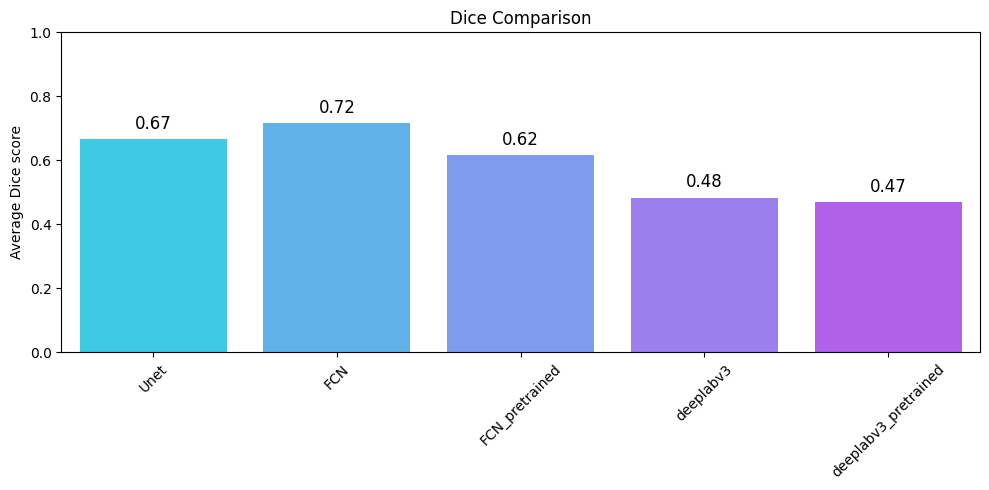

In [ ]:
Model_names = ["Unet",
               "FCN",
               "FCN_pretrained",
               "deeplabv3",
               "deeplabv3_pretrained"]

Dices_lst = [Dice_score_Unet.mean().item(),
             Dice_score_FCN.mean().item(),
             Dice_score_FCN_pretrained.mean().item(),
             Dice_score_deeplabv3.mean().item(),
             Dice_score_deeplabv3_pretrained.mean().item()]


plt.figure(figsize=(10,5))
ax = sns.barplot(x=Model_names, y=Dices_lst, palette=sns.color_palette(palette='cool'))
for i, value in enumerate(Dices_lst):
    ax.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12)
plt.title("Dice Comparison")
plt.ylabel("Average Dice score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-39-abc81c8df2c4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_2 = sns.barplot(x=Model_names, y=HD95_lst, palette=sns.color_palette(palette='cool'))
<ipython-input-39-abc81c8df2c4>:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax_2 = sns.barplot(x=Model_names, y=HD95_lst, palette=sns.color_palette(palette='cool'))


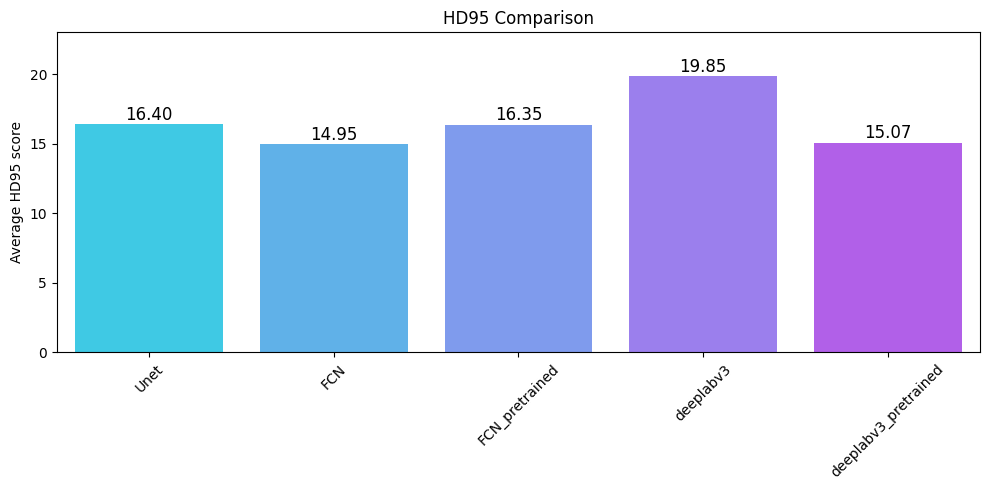

In [ ]:
HD95_lst = [HD95_score_Unet.mean().item(),
            HD95_score_FCN.mean().item(),
            HD95_score_FCN_pretrained.mean().item(),
            HD95_score_deeplabv3.mean().item(),
            HD95_score_deeplabv3_pretrained.mean().item()]

plt.figure(figsize=(10,5))
ax_2 = sns.barplot(x=Model_names, y=HD95_lst, palette=sns.color_palette(palette='cool'))
for i, value in enumerate(HD95_lst):
    ax_2.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12)
plt.title("HD95 Comparison")
plt.ylabel("Average HD95 score")
plt.ylim(0, 23)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()